In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.tensorflow
import mlflow.catboost
from mlflow.tracking import MlflowClient


In [2]:
SEED_VALUE = 42
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
def setup_mlflow():
    """Setup MLflow tracking"""
    
    # Set experiment name
    experiment_name = "instacart_market_basket_analysis"
    
    try:
        # Create experiment if it doesn't exist
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Created new experiment: {experiment_name}")
    except:
        # Experiment already exists
        experiment = mlflow.get_experiment_by_name(experiment_name)
        experiment_id = experiment.experiment_id
        print(f"Using existing experiment: {experiment_name}")
    
    # Set the experiment
    mlflow.set_experiment(experiment_name)
    
    print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
    print(f"Experiment ID: {experiment_id}")
    
    return experiment_id

# Setup MLflow
experiment_id = setup_mlflow()


Created new experiment: instacart_market_basket_analysis
MLflow tracking URI: file:///Users/dharmikbhagat/ecommerce-recommender/notebooks/mlruns
Experiment ID: 265517844822911815


In [14]:
from minio import Minio
import os

# Configuration
MINIO_ENDPOINT = "localhost:9000"
ACCESS_KEY = "minioadmin"
SECRET_KEY = "minioadmin"
BUCKET_NAME = "instacart-data"
REMOTE_PREFIX = "processed/"
LOCAL_FOLDER = "/Users/dharmikbhagat/ecommerce-recommender/data/processed"

# Initialize MinIO client
client = Minio(
    MINIO_ENDPOINT,
    access_key=ACCESS_KEY,
    secret_key=SECRET_KEY,
    secure=False
)

def load_data_from_minio():
    """Download all CSV files from MinIO 'processed/' prefix into local 'processed/' folder"""
    print("Downloading files from MinIO...")
    
    try:
        # Create local folder if not exists
        os.makedirs(LOCAL_FOLDER, exist_ok=True)
        print(f"Local folder: {LOCAL_FOLDER}")
        
        # Test connection first
        if not client.bucket_exists(BUCKET_NAME):
            print(f"Bucket '{BUCKET_NAME}' does not exist!")
            return False
        
        print(f"Connected to bucket: {BUCKET_NAME}")
        
        # List all objects under the 'processed/' prefix
        print(f"🔍 Searching for files with prefix: {REMOTE_PREFIX}")
        objects = client.list_objects(BUCKET_NAME, prefix=REMOTE_PREFIX, recursive=True)
        
        downloaded_count = 0
        
        for obj in objects:
            print(f"Found object: {obj.object_name}")
            
            # Download all files (not just CSV) or modify condition as needed
            if obj.object_name.endswith((".csv", ".txt")):  # Added .txt for placeholder.txt
                file_name = obj.object_name.split("/")[-1]
                local_path = os.path.join(LOCAL_FOLDER, file_name)
                
                print(f"Downloading {file_name} ({obj.size} bytes)...")
                
                try:
                    client.fget_object(BUCKET_NAME, obj.object_name, local_path)
                    print(f" Successfully downloaded: {file_name}")
                    downloaded_count += 1
                except Exception as download_error:
                    print(f"Failed to download {file_name}: {download_error}")
            else:
                print(f"⏭Skipping non-CSV/TXT file: {obj.object_name}")
        
        if downloaded_count == 0:
            print(" No files were downloaded. Check your configuration.")
            return False
        else:
            print(f"Successfully downloaded {downloaded_count} files to {LOCAL_FOLDER}")
            return True
            
    except Exception as e:
        print(f" Error occurred: {e}")
        return False

def test_connection():
    """Test MinIO connection and list available buckets"""
    try:
        print("Testing MinIO connection...")
        buckets = client.list_buckets()
        print("Available buckets:")
        for bucket in buckets:
            print(f"  - {bucket.name} (created: {bucket.creation_date})")
        return True
    except Exception as e:
        print(f" Connection failed: {e}")
        return False

def list_remote_files():
    """List all files in the remote processed/ directory"""
    try:
        print(f" Files in {BUCKET_NAME}/{REMOTE_PREFIX}:")
        objects = client.list_objects(BUCKET_NAME, prefix=REMOTE_PREFIX, recursive=True)
        
        for obj in objects:
            size_mb = obj.size / (1024 * 1024) if obj.size > 1024 * 1024 else obj.size / 1024
            size_unit = "MB" if obj.size > 1024 * 1024 else "KB"
            print(f"   {obj.object_name} ({size_mb:.1f} {size_unit})")
            
    except Exception as e:
        print(f" Error listing files: {e}")

if __name__ == "__main__":
    # Test the functions
    print("=== MinIO Connection Test ===")
    if test_connection():
        print("\n=== Remote Files List ===")
        list_remote_files()
        
        print("\n=== Download Files ===")
        load_data_from_minio()
    else:
        print("Please check your MinIO configuration and ensure MinIO is running.")

=== MinIO Connection Test ===
Testing MinIO connection...
Available buckets:
  - instacart-data (created: 2025-06-12 19:33:28.514000+00:00)

=== Remote Files List ===
 Files in instacart-data/processed/:
   processed/day_reorder_rate.csv (7.7 MB)
   processed/days_since_prior_reorder_rate.csv (619.3 MB)
   processed/hour_reorder_rate.csv (20.1 MB)
   processed/p_days_since_prior_order_reorder_rate.csv (27.3 MB)
   processed/placeholder.txt (0.0 KB)
   processed/prior_combined.csv (3033.8 MB)
   processed/products_merged.csv (3.2 MB)
   processed/train_combined.csv (130.2 MB)
   processed/u_days_since_prior_order_reorder_rate.csv (42.4 MB)
   processed/user_product_features.csv (622.4 MB)

=== Download Files ===
Local folder: /Users/dharmikbhagat/ecommerce-recommender/data/processed
Connected to bucket: instacart-data
🔍 Searching for files with prefix: processed/
Found object: processed/day_reorder_rate.csv
 Successfully downloaded: day_reorder_rate.csv
Found object: processed/days_sinc

In [3]:
def load_data_local():
    """Load data files from local directory"""
    
    print("Loading data files from local directory...")
    
    with mlflow.start_run(run_name="data_loading", nested=True):
        try:
            # Load processed feature files (modify paths as needed)
            day_reorder_rate = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/day_reorder_rate.csv')
            hour_reorder_rate = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/hour_reorder_rate.csv')
            p_days_since_prior_order_reorder_rate = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/p_days_since_prior_order_reorder_rate.csv')
            u_days_since_prior_order_reorder_rate = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/u_days_since_prior_order_reorder_rate.csv')
            days_since_prior_reorder_rate = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/days_since_prior_reorder_rate.csv')
            prior_combined = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/prior_combined.csv')
            train_combined = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/train_combined.csv')
            user_product_features = pd.read_csv('/Users/dharmikbhagat/ecommerce-recommender/data/processed/user_product_features.csv')
            
            # Log shapes
            mlflow.log_param("day_reorder_rate_shape", str(day_reorder_rate.shape))
            mlflow.log_param("hour_reorder_rate_shape", str(hour_reorder_rate.shape))
            mlflow.log_param("user_product_features_shape", str(user_product_features.shape))
            
            print(f"✓ All files loaded successfully")
            print(f"✓ User product features: {user_product_features.shape}")
            print(f"✓ Train combined: {train_combined.shape}")
            
            return {
                'day_reorder_rate': day_reorder_rate,
                'hour_reorder_rate': hour_reorder_rate,
                'p_days_since_prior_order_reorder_rate': p_days_since_prior_order_reorder_rate,
                'u_days_since_prior_order_reorder_rate': u_days_since_prior_order_reorder_rate,
                'days_since_prior_reorder_rate': days_since_prior_reorder_rate,
                'prior_combined': prior_combined,
                'train_combined': train_combined,
                'user_product_features': user_product_features
            }
            
        except Exception as e:
            print(f"Error loading files: {e}")
            return None

In [4]:
data_files = load_data_local()

Loading data files from local directory...
✓ All files loaded successfully
✓ User product features: (13307953, 7)
✓ Train combined: (1384617, 15)


In [9]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)>

In [5]:
data_files

{'day_reorder_rate':         product_id  order_dow  day_reorder_rate
 0                1          0          0.108531
 1                1          1          0.215983
 2                1          2          0.146328
 3                1          3          0.141469
 4                1          4          0.159287
 ...            ...        ...               ...
 317897       49688          2          0.134831
 317898       49688          3          0.123596
 317899       49688          4          0.123596
 317900       49688          5          0.101124
 317901       49688          6          0.112360
 
 [317902 rows x 3 columns],
 'hour_reorder_rate':         product_id  order_hour_of_day  hour_reorder_rate
 0                1                  0           0.006479
 1                1                  1           0.005940
 2                1                  2           0.004860
 3                1                  3           0.002700
 4                1                  4           0.

In [8]:
data_files['train_combined']

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,169679,train,30,0,10,4.0,Natural Artesian Water,115,7,water seltzer sparkling water,beverages
1384613,3421063,35548,4,1,169679,train,30,0,10,4.0,Twice Baked Potatoes,13,20,prepared meals,deli
1384614,3421070,35951,1,1,139822,train,15,6,10,8.0,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
1384615,3421070,16953,2,1,139822,train,15,6,10,8.0,Creamy Peanut Butter,88,13,spreads,pantry


In [27]:
import mlflow
mlflow.set_tracking_uri("file:///Users/dharmikbhagat/ecommerce-recommender/notebooks/mlruns")
experiment = mlflow.get_experiment_by_name("instacart_market_basket_analysis")
print(experiment)

Traceback (most recent call last):
  File "/Users/dharmikbhagat/ecommerce-recommender/venv_1/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/Users/dharmikbhagat/ecommerce-recommender/venv_1/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Users/dharmikbhagat/ecommerce-recommender/venv_1/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Users/dharmikbhagat/ecommerce-recommender/venv_1/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1581, in _read_helper
    result = read_yaml(root, file_name)
  File "/Users/dharmikbhagat/ecommerce-recommender/venv_1/lib/python3.10/site-packages/mlflow/utils/yaml_utils.py"

<Experiment: artifact_location='file:///Users/dharmikbhagat/ecommerce-recommender/notebooks/mlruns/265517844822911815', creation_time=1749928265774, experiment_id='265517844822911815', last_update_time=1749928265774, lifecycle_stage='active', name='instacart_market_basket_analysis', tags={}>


In [28]:
import mlflow
import os

# Set the correct path
tracking_uri = "file:///Users/dharmikbhagat/ecommerce-recommender/notebooks/mlruns"
mlflow.set_tracking_uri(tracking_uri)

# Get your specific experiment
experiment_id = "265517844822911815"
experiment = mlflow.get_experiment(experiment_id)
print("Experiment Details:")
print(f"Name: {experiment.name}")
print(f"ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

# List all runs in this experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id])
print(f"\nFound {len(runs)} runs:")
print(runs.columns.tolist())
if len(runs) > 0:
    print(runs[['run_id', 'status', 'start_time']].head())
    

Experiment Details:
Name: instacart_market_basket_analysis
ID: 265517844822911815
Artifact Location: file:///Users/dharmikbhagat/ecommerce-recommender/notebooks/mlruns/265517844822911815

Found 5 runs:
['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'params.user_product_features_shape', 'params.day_reorder_rate_shape', 'params.hour_reorder_rate_shape', 'params.data_loading_status', 'params.error', 'tags.mlflow.source.type', 'tags.mlflow.user', 'tags.mlflow.source.name', 'tags.mlflow.runName']
                             run_id    status                       start_time
0  3ccfaf44110c4c05a2364a8079ac37dc  FINISHED 2025-06-14 19:54:24.703000+00:00
1  52b1d9827ef14f139529ea638875a888  FINISHED 2025-06-14 19:52:03.311000+00:00
2  0f5d0ecc8011446db5e4da5999e79a89  FINISHED 2025-06-14 19:51:41.663000+00:00
3  0e4002c3a322458ea0b23b5aea5b2ed8  FINISHED 2025-06-14 19:49:51.451000+00:00
4  15cefe5483d34e089150d0128fbc5174  FINISHED 2025-06-14 19:31:02.782000+00

In [29]:
def explore_data(data_files):
    """Explore the loaded datasets"""
    
    if data_files is None:
        print("No data to explore")
        return
    
    print("="*60)
    print("DATA EXPLORATION")
    print("="*60)
    
    # Display basic info about each dataset
    for name, df in data_files.items():
        print(f"\n{name.upper()}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Show first few rows
        print(f"  First 3 rows:")
        display(df.head(3))
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(f"  Missing values: {missing[missing > 0]}")
        else:
            print("  No missing values")

In [30]:
if data_files:
    explore_data(data_files)

DATA EXPLORATION

DAY_REORDER_RATE:
  Shape: (317902, 3)
  Columns: ['product_id', 'order_dow', 'day_reorder_rate']
  Memory usage: 7.28 MB
  First 3 rows:


,product_id,order_dow,day_reorder_rate
0,1,0,0.108531
1,1,1,0.215983
2,1,2,0.146328


  No missing values

HOUR_REORDER_RATE:
  Shape: (767868, 3)
  Columns: ['product_id', 'order_hour_of_day', 'hour_reorder_rate']
  Memory usage: 17.58 MB
  First 3 rows:


,product_id,order_hour_of_day,hour_reorder_rate
0,1,0,0.006479
1,1,1,0.005940
2,1,2,0.004860


  No missing values

P_DAYS_SINCE_PRIOR_ORDER_REORDER_RATE:
  Shape: (963864, 3)
  Columns: ['product_id', 'days_since_prior_order', 'p_days_since_prior_order_reorder_rate']
  Memory usage: 22.06 MB
  First 3 rows:


,product_id,days_since_prior_order,p_days_since_prior_order_reorder_rate
0,1,0.0,0.049136
1,1,1.0,0.051836
2,1,2.0,0.048596


  No missing values

U_DAYS_SINCE_PRIOR_ORDER_REORDER_RATE:
  Shape: (1485775, 3)
  Columns: ['user_id', 'days_since_prior_order', 'u_days_since_prior_order_reorder_rate']
  Memory usage: 34.01 MB
  First 3 rows:


,user_id,days_since_prior_order,u_days_since_prior_order_reorder_rate
0,1,0.0,0.101695
1,1,14.0,0.101695
2,1,15.0,0.101695


  No missing values

DAYS_SINCE_PRIOR_REORDER_RATE:
  Shape: (25238902, 4)
  Columns: ['user_id', 'product_id', 'days_since_prior_order', 'days_since_prior_reorder_rate']
  Memory usage: 770.23 MB
  First 3 rows:


,user_id,product_id,days_since_prior_order,days_since_prior_reorder_rate
0,1,196,0.0,0.1
1,1,196,14.0,0.1
2,1,196,15.0,0.1


  Missing values: days_since_prior_order           868069
days_since_prior_reorder_rate    868069
dtype: int64

PRIOR_COMBINED:
  Shape: (32434489, 15)
  Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']
  Memory usage: 11401.25 MB
  First 3 rows:


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry


  Missing values: days_since_prior_order    2078068
dtype: int64

TRAIN_COMBINED:
  Shape: (1384617, 15)
  Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']
  Memory usage: 486.78 MB
  First 3 rows:


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce


  No missing values

USER_PRODUCT_FEATURES:
  Shape: (13307953, 7)
  Columns: ['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak']
  Memory usage: 710.72 MB
  First 3 rows:


,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak
0,1,196,0.169492,0.900000,1.400000,0,6
1,1,10258,0.152542,0.888889,3.333333,0,5
2,1,10326,0.016949,0.000000,5.000000,5,0


  No missing values


Creating reorder pattern visualizations...


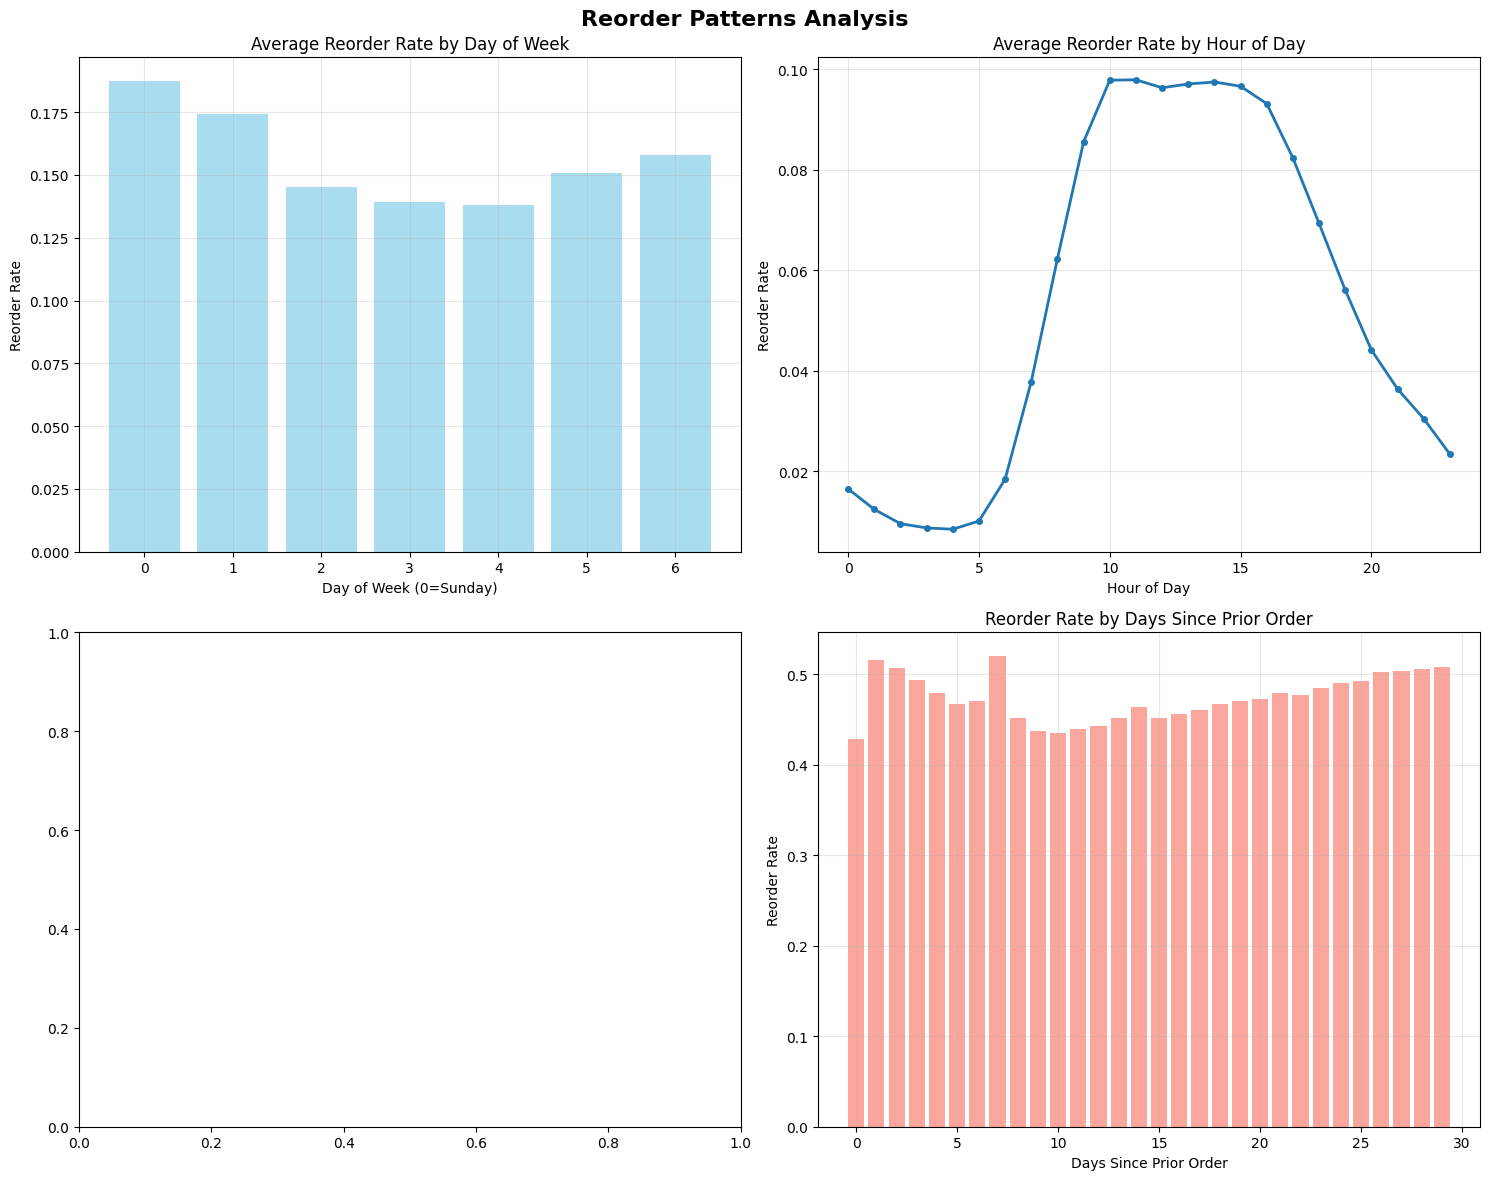

In [31]:
def visualize_reorder_patterns(data_files):
    """Create visualizations of reorder patterns"""
    
    if data_files is None:
        return
    
    print("Creating reorder pattern visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Reorder Patterns Analysis', fontsize=16, fontweight='bold')
    
    # 1. Day of week reorder rates
    if 'day_reorder_rate' in data_files:
        day_data = data_files['day_reorder_rate'].groupby('order_dow')['day_reorder_rate'].mean()
        axes[0, 0].bar(day_data.index, day_data.values, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Average Reorder Rate by Day of Week')
        axes[0, 0].set_xlabel('Day of Week (0=Sunday)')
        axes[0, 0].set_ylabel('Reorder Rate')
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Hour of day reorder rates
    if 'hour_reorder_rate' in data_files:
        hour_data = data_files['hour_reorder_rate'].groupby('order_hour_of_day')['hour_reorder_rate'].mean()
        axes[0, 1].plot(hour_data.index, hour_data.values, marker='o', linewidth=2, markersize=4)
        axes[0, 1].set_title('Average Reorder Rate by Hour of Day')
        axes[0, 1].set_xlabel('Hour of Day')
        axes[0, 1].set_ylabel('Reorder Rate')
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. User product features distribution
    if 'user_product_features' in data_files:
        up_features = data_files['user_product_features']
        if 'up_order_rate' in up_features.columns:
            axes[1, 0].hist(up_features['up_order_rate'], bins=50, alpha=0.7, color='lightgreen')
            axes[1, 0].set_title('Distribution of User-Product Order Rates')
            axes[1, 0].set_xlabel('Order Rate')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Days since prior order pattern
    if 'days_since_prior_reorder_rate' in data_files:
        days_data = data_files['days_since_prior_reorder_rate']
        if 'days_since_prior_order' in days_data.columns:
            days_summary = days_data.groupby('days_since_prior_order')['days_since_prior_reorder_rate'].mean()
            # Limit to first 30 days for better visualization
            days_summary = days_summary.head(30)
            axes[1, 1].bar(days_summary.index, days_summary.values, alpha=0.7, color='salmon')
            axes[1, 1].set_title('Reorder Rate by Days Since Prior Order')
            axes[1, 1].set_xlabel('Days Since Prior Order')
            axes[1, 1].set_ylabel('Reorder Rate')
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if data_files:
    visualize_reorder_patterns(data_files)

In [32]:
def create_merged_dataset(data_files):
    """Merge all features to create the final training dataset"""
    
    print("\n" + "="*50)
    print("CREATING MERGED DATASET")
    print("="*50)
    
    with mlflow.start_run(run_name="data_merging", nested=True):
        # Start with user-product features as base
        merged_df = data_files['user_product_features'].copy()
        print(f"Starting with user-product features: {merged_df.shape}")
        mlflow.log_param("initial_features_shape", str(merged_df.shape))
        
        # Get train order data
        train_order_data = data_files['train_combined'].copy()
        print(f"Train order data shape: {train_order_data.shape}")
        
        # Process train orders
        upd_train_orders = train_order_data[['user_id','order_id','product_id','reordered']].copy()
        
        # Get last orders for each user
        last_orders = upd_train_orders.groupby(['user_id'])['order_id'].max().reset_index()
        last_orders.rename(columns={'order_id': 'new_order_id'}, inplace=True)
        
        # Get order details
        order_details = train_order_data[['order_id','order_dow','order_hour_of_day','days_since_prior_order']].drop_duplicates()
        
        # Start merging process
        print("\nMerging datasets...")
        
        # Merge with train orders
        train_orders_merged_df = pd.merge(merged_df, upd_train_orders, 
                                        how='left', on=['user_id','product_id'])
        print(f"After merging with train orders: {train_orders_merged_df.shape}")
        
        # Merge with last orders
        train_orders_merged_df = pd.merge(train_orders_merged_df, last_orders, on='user_id')
        
        # Clean up order_id columns
        train_orders_merged_df.drop("order_id", axis=1, inplace=True)
        train_orders_merged_df.rename(columns={'new_order_id':'order_id'}, inplace=True)
        
        # Merge with order details
        train_orders_merged_df = pd.merge(train_orders_merged_df, order_details, on='order_id')
        print(f"After merging with order details: {train_orders_merged_df.shape}")
        
        # Fill missing reordered values
        train_orders_merged_df['reordered'] = train_orders_merged_df['reordered'].fillna(0.0)
        
        # Merge with time-based features
        print("\nMerging with time-based features...")
        
        # Hour reorder rate
        train_orders_merged_df = pd.merge(train_orders_merged_df, 
                                        data_files['hour_reorder_rate'], 
                                        on=['product_id','order_hour_of_day'], 
                                        how='left')
        train_orders_merged_df['hour_reorder_rate'] = train_orders_merged_df['hour_reorder_rate'].fillna(0.0)
        
        # Day reorder rate
        train_orders_merged_df = pd.merge(train_orders_merged_df, 
                                        data_files['day_reorder_rate'], 
                                        on=['product_id','order_dow'], 
                                        how='left')
        train_orders_merged_df['day_reorder_rate'] = train_orders_merged_df['day_reorder_rate'].fillna(0.0)
        
        # Product days since prior order reorder rate
        train_orders_merged_df = pd.merge(train_orders_merged_df, 
                                        data_files['p_days_since_prior_order_reorder_rate'], 
                                        on=['product_id','days_since_prior_order'], 
                                        how='left')
        train_orders_merged_df['p_days_since_prior_order_reorder_rate'] = train_orders_merged_df['p_days_since_prior_order_reorder_rate'].fillna(0.0)
        
        # User days since prior order reorder rate
        train_orders_merged_df = pd.merge(train_orders_merged_df, 
                                        data_files['u_days_since_prior_order_reorder_rate'], 
                                        on=['user_id','days_since_prior_order'], 
                                        how='left')
        train_orders_merged_df['u_days_since_prior_order_reorder_rate'] = train_orders_merged_df['u_days_since_prior_order_reorder_rate'].fillna(0.0)
        
        # Days since prior reorder rate
        train_orders_merged_df = pd.merge(train_orders_merged_df, 
                                        data_files['days_since_prior_reorder_rate'], 
                                        on=["user_id","product_id",'days_since_prior_order'], 
                                        how='left')
        train_orders_merged_df['days_since_prior_reorder_rate'] = train_orders_merged_df['days_since_prior_reorder_rate'].fillna(0.0)
        
        print(f"Final merged dataset shape: {train_orders_merged_df.shape}")
        
        # Log to MLflow
        mlflow.log_param("final_dataset_shape", str(train_orders_merged_df.shape))
        mlflow.log_param("final_features_count", train_orders_merged_df.shape[1] - 1)  # -1 for target
        mlflow.log_param("target_distribution", str(train_orders_merged_df['reordered'].value_counts().to_dict()))
        mlflow.log_metric("positive_class_ratio", train_orders_merged_df['reordered'].mean())
        
        return train_orders_merged_df


In [33]:
if data_files:
    final_dataset = create_merged_dataset(data_files)
    print(f"\nFinal dataset created with shape: {final_dataset.shape}")
    print(f"Target distribution:\n{final_dataset['reordered'].value_counts()}")
    
    # Display dataset info
    print(f"\nDataset Info:")
    print(f"Features: {final_dataset.shape[1] - 1}")
    print(f"Samples: {final_dataset.shape[0]}")
    print(f"Positive class ratio: {final_dataset['reordered'].mean():.4f}")
    
    # Show feature names
    feature_cols = [col for col in final_dataset.columns if col not in ['user_id', 'product_id', 'order_id', 'reordered']]
    print(f"\nFeature columns ({len(feature_cols)}):")
    for col in feature_cols:
        print(f"  - {col}")
else:
    print("Cannot proceed without data files")


CREATING MERGED DATASET
Starting with user-product features: (13307953, 7)
Train order data shape: (1384617, 15)

Merging datasets...
After merging with train orders: (13307953, 9)
After merging with order details: (8474661, 12)

Merging with time-based features...
Final merged dataset shape: (8474661, 17)

Final dataset created with shape: (8474661, 17)
Target distribution:
reordered
0.0    7645837
1.0     828824
Name: count, dtype: int64

Dataset Info:
Features: 16
Samples: 8474661
Positive class ratio: 0.0978

Feature columns (13):
  - u_p_order_rate
  - u_p_reorder_rate
  - u_p_avg_position
  - u_p_orders_since_last
  - max_streak
  - order_dow
  - order_hour_of_day
  - days_since_prior_order
  - hour_reorder_rate
  - day_reorder_rate
  - p_days_since_prior_order_reorder_rate
  - u_days_since_prior_order_reorder_rate
  - days_since_prior_reorder_rate


In [34]:
final_dataset

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,reordered,order_id,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,0.169492,0.900000,1.400000,0,6,1.0,1187899,4,8,14.0,0.059652,0.152580,0.038725,0.101695,0.100000
1,1,10258,0.152542,0.888889,3.333333,0,5,1.0,1187899,4,8,14.0,0.062179,0.137718,0.041110,0.101695,0.111111
2,1,10326,0.016949,0.000000,5.000000,5,0,0.0,1187899,4,8,14.0,0.066956,0.123959,0.035831,0.101695,0.000000
3,1,12427,0.169492,0.900000,3.300000,0,6,0.0,1187899,4,8,14.0,0.065318,0.130173,0.041847,0.101695,0.100000
4,1,13032,0.050847,0.666667,6.333333,0,1,1.0,1187899,4,8,14.0,0.061584,0.144495,0.032791,0.101695,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,0.023256,0.666667,8.000000,1,1,0.0,272231,6,14,30.0,0.084539,0.139477,0.088187,0.302326,0.333333
8474657,206209,44325,0.007752,0.000000,8.000000,6,0,0.0,272231,6,14,30.0,0.080631,0.151220,0.122238,0.302326,0.000000
8474658,206209,48370,0.007752,0.000000,8.000000,2,0,0.0,272231,6,14,30.0,0.080071,0.134723,0.094814,0.302326,1.000000
8474659,206209,48697,0.007752,0.000000,6.000000,6,0,0.0,272231,6,14,30.0,0.082286,0.154758,0.107636,0.302326,0.000000


In [35]:
def prepare_ml_data(df):
    """Prepare data for machine learning"""
    
    print("\n" + "="*50)
    print("PREPARING DATA FOR ML")
    print("="*50)
    
    with mlflow.start_run(run_name="data_preparation", nested=True):
        # Display basic info
        print(f"Dataset shape: {df.shape}")
        print(f"Missing values: {df.isnull().sum().sum()} total missing values")
        
        # Separate features and target
        # Remove non-predictive columns
        columns_to_drop = ['user_id', 'product_id', 'order_id']
        
        # Check which columns exist in the dataset
        cols_to_drop = [col for col in columns_to_drop if col in df.columns]
        
        X = df.drop(cols_to_drop + ['reordered'], axis=1)
        y = df['reordered']
        
        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        print(f"Feature columns: {list(X.columns)}")
        
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=SEED_VALUE, stratify=y
        )
        
        print(f"\nTrain set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Train target distribution: {y_train.value_counts().to_dict()}")
        print(f"Validation target distribution: {y_val.value_counts().to_dict()}")
        
        # Normalize features for neural network and logistic regression
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_val_norm = scaler.transform(X_val)
        
        print("✓ Data normalization completed")
        
        # Log to MLflow
        mlflow.log_param("train_size", X_train.shape[0])
        mlflow.log_param("validation_size", X_val.shape[0])
        mlflow.log_param("feature_count", X_train.shape[1])
        mlflow.log_param("test_split_ratio", 0.2)
        mlflow.log_param("random_state", SEED_VALUE)
        mlflow.log_metric("train_positive_ratio", y_train.mean())
        mlflow.log_metric("val_positive_ratio", y_val.mean())
        
        # Log feature names
        mlflow.log_param("feature_names", list(X.columns))
        
        return X_train, X_val, y_train, y_val, X_train_norm, X_val_norm, scaler

# Prepare the data
if 'final_dataset' in locals():
    X_train, X_val, y_train, y_val, X_train_norm, X_val_norm, scaler = prepare_ml_data(final_dataset)


PREPARING DATA FOR ML
Dataset shape: (8474661, 17)
Missing values: 0 total missing values
Features shape: (8474661, 13)
Target shape: (8474661,)
Feature columns: ['u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']

Train set: (6779728, 13)
Validation set: (1694933, 13)
Train target distribution: {0.0: 6116669, 1.0: 663059}
Validation target distribution: {0.0: 1529168, 1.0: 165765}
✓ Data normalization completed


In [37]:
with mlflow.start_run(run_name="logistic_regression"):
    log_reg = LogisticRegression(random_state=0, n_jobs=-1, max_iter=1000)
    log_reg.fit(X_train_norm, y_train)
    
    # Predict probabilities for validation
    predict_y = log_reg.predict_proba(X_val_norm)
    
    # Evaluate log loss
    val_logloss = log_loss(y_val, predict_y, labels=[0, 1])
    print("Logloss on validation data:", val_logloss)

    # Log parameters and metrics to MLflow
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("log_loss_val", val_logloss)
    
    # Log the model
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")


2025/06/15 18:07:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logloss on validation data: 0.2617879046819678


2025/06/15 18:07:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [38]:
with mlflow.start_run(run_name="decision_tree"):
    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 3, 4, 5]
    }

    dt_clf = DecisionTreeClassifier(random_state=SEED_VALUE)
    r_search = RandomizedSearchCV(
        dt_clf,
        param_distributions=param_grid,
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    r_search.fit(X_train, y_train)
    predict_y = r_search.predict_proba(X_val)

    val_logloss = log_loss(y_val, predict_y, labels=[0, 1])
    print("Logloss on validation data:", val_logloss)

    # Log best parameters and metric
    mlflow.log_params(r_search.best_params_)
    mlflow.log_param("model_type", "DecisionTreeClassifier")
    mlflow.log_metric("log_loss_val", val_logloss)

    # Log the best model
    mlflow.sklearn.log_model(r_search.best_estimator_, "decision_tree_model")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025/06/15 18:15:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logloss on validation data: 0.2548914219590189


python(86805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/06/15 18:15:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [39]:
with mlflow.start_run(run_name="random_forest_with_calibration"):
    clf = RandomForestClassifier(n_estimators=25, random_state=SEED_VALUE, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Calibrate classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    # Predict and evaluate
    predict_y = sig_clf.predict_proba(X_val)
    val_logloss = log_loss(y_val, predict_y, labels=[0, 1])
    print("Logloss on validation data:", val_logloss)

    # Log parameters and metrics
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", 25)
    mlflow.log_param("calibration", "sigmoid")
    mlflow.log_metric("log_loss_val", val_logloss)

    # Log the calibrated model
    mlflow.sklearn.log_model(sig_clf, "random_forest_calibrated_model")


2025/06/15 18:21:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logloss on validation data: 0.259368223598232


python(86977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/06/15 18:22:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [54]:
def mlp_model():
    """
    Create MLP model with 5 hidden layers.
    """
    inp = Input(shape=(13,))
    mlp = Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name='fc_1')(inp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name='fc_2')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name='fc_3')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name='fc_4')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(1, activation="sigmoid", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name='output')(mlp)

    model = Model(inputs=inp, outputs=mlp)
    opt = Adam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [53]:
X_train.shape

(6779728, 13)

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create model
model = mlp_model()

# Define callbacks
checkpoint_path = "saved_model/mlp/checkpoint.keras"
checkpoint = checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train model with MLflow tracking
with mlflow.start_run(run_name="mlp_model"):
    history = model.fit(
        X_train_norm, np.array(y_train).reshape(-1, 1),
        epochs=10,
        batch_size=128,
        validation_data=(X_val_norm, np.array(y_val).reshape(-1, 1)),
        callbacks=[checkpoint, earlystop],
        verbose=2
    )

    # Load best model
    saved_model = tf.keras.models.load_model(checkpoint_path)

    # Evaluate
    train_acc = saved_model.evaluate(X_train_norm, np.array(y_train).reshape(-1, 1), verbose=0)[1]
    val_acc = saved_model.evaluate(X_val_norm, np.array(y_val).reshape(-1, 1), verbose=0)[1]
    val_preds = saved_model.predict(X_val_norm)
    val_logloss = log_loss(y_val, val_preds, labels=[0, 1])

    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")
    print("Validation Log Loss:", val_logloss)

    # Log to MLflow
    mlflow.log_param("model_type", "MLP")
    mlflow.log_param("layers", [256, 128, 64, 32, 16])
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.log_metric("log_loss_val", val_logloss)
    mlflow.tensorflow.log_model(saved_model, "mlp_model")


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.25610, saving model to saved_model/mlp/checkpoint.keras
52967/52967 - 48s - 900us/step - accuracy: 0.9038 - loss: 0.2630 - val_accuracy: 0.9048 - val_loss: 0.2561
Epoch 2/10

Epoch 2: val_loss improved from 0.25610 to 0.25587, saving model to saved_model/mlp/checkpoint.keras
52967/52967 - 46s - 863us/step - accuracy: 0.9047 - loss: 0.2590 - val_accuracy: 0.9044 - val_loss: 0.2559
Epoch 3/10

Epoch 3: val_loss improved from 0.25587 to 0.25567, saving model to saved_model/mlp/checkpoint.keras
52967/52967 - 44s - 830us/step - accuracy: 0.9047 - loss: 0.2587 - val_accuracy: 0.9043 - val_loss: 0.2557
Epoch 4/10

Epoch 4: val_loss improved from 0.25567 to 0.25533, saving model to saved_model/mlp/checkpoint.keras
52967/52967 - 44s - 822us/step - accuracy: 0.9047 - loss: 0.2586 - val_accuracy: 0.9048 - val_loss: 0.2553
Epoch 5/10

Epoch 5: val_loss did not improve from 0.25533
52967/52967 - 46s - 863us/step - accuracy: 0.9046 - loss: 0.2587 

2025/06/15 18:40:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 18:40:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Training Accuracy: 90.57%
Validation Accuracy: 90.58%
Validation Log Loss: 0.25490406822643935


python(87255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/06/15 18:40:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [58]:
def train_xgb(X_train, X_test, y_train, y_test, plot_importance=True, save=True, file_name=None, params=None):
    """
    Train XGBoost model with optional feature importance plotting and saving.
    Logs metrics and model to MLflow.

    Returns:
        xgb_model: Trained XGBoost model
        predict_y: Predicted probabilities for validation data
    """
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'eta': 0.02,
            'max_depth': 15,
            'nthread': -1,
            'colsample_bytree': 0.4,
            'tree_method': 'hist'
        }

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(d_train, 'train'), (d_test, 'valid')]

    with mlflow.start_run(run_name="xgboost_model"):
        print("Training Started:")
        start_time = datetime.now()
        xgb_model = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=20, verbose_eval=10)
        end_time = datetime.now()
        print("Training Completed")
        total_time = end_time - start_time
        minutes, seconds = divmod(total_time.total_seconds(), 60)
        print(f"Total Time: {int(minutes)} minutes {int(seconds)} seconds")

        predict_y = xgb_model.predict(d_test)
        val_logloss = log_loss(y_test, predict_y, labels=[0, 1])
        print("The test log loss is:", val_logloss)

        mlflow.log_params(params)
        mlflow.log_metric("log_loss_val", val_logloss)
        mlflow.xgboost.log_model(xgb_model, "xgboost_model")

        if save and file_name:
            pickle.dump(xgb_model, open(file_name, "wb"))

        if plot_importance:
            print("Feature Importance")
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            xgb.plot_importance(booster=xgb_model, ax=ax)
            plt.show()

        return xgb_model, predict_y


Training Started:
[0]	train-logloss:0.31704	valid-logloss:0.31714
[10]	train-logloss:0.30012	valid-logloss:0.30161
[20]	train-logloss:0.28840	valid-logloss:0.29101
[30]	train-logloss:0.27962	valid-logloss:0.28317
[40]	train-logloss:0.27178	valid-logloss:0.27639
[50]	train-logloss:0.26461	valid-logloss:0.27014
[60]	train-logloss:0.26049	valid-logloss:0.26693
[70]	train-logloss:0.25636	valid-logloss:0.26366
[80]	train-logloss:0.25363	valid-logloss:0.26180
[90]	train-logloss:0.25128	valid-logloss:0.26032
[100]	train-logloss:0.24900	valid-logloss:0.25877
[110]	train-logloss:0.24697	valid-logloss:0.25751
[120]	train-logloss:0.24537	valid-logloss:0.25678
[130]	train-logloss:0.24375	valid-logloss:0.25586
[140]	train-logloss:0.24228	valid-logloss:0.25516
[150]	train-logloss:0.24106	valid-logloss:0.25472
[160]	train-logloss:0.23982	valid-logloss:0.25418
[170]	train-logloss:0.23878	valid-logloss:0.25382
[180]	train-logloss:0.23758	valid-logloss:0.25335
[190]	train-logloss:0.23667	valid-logloss:0

2025/06/15 18:43:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


The test log loss is: 0.2513241124220334


python(87337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/06/15 18:43:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Importance


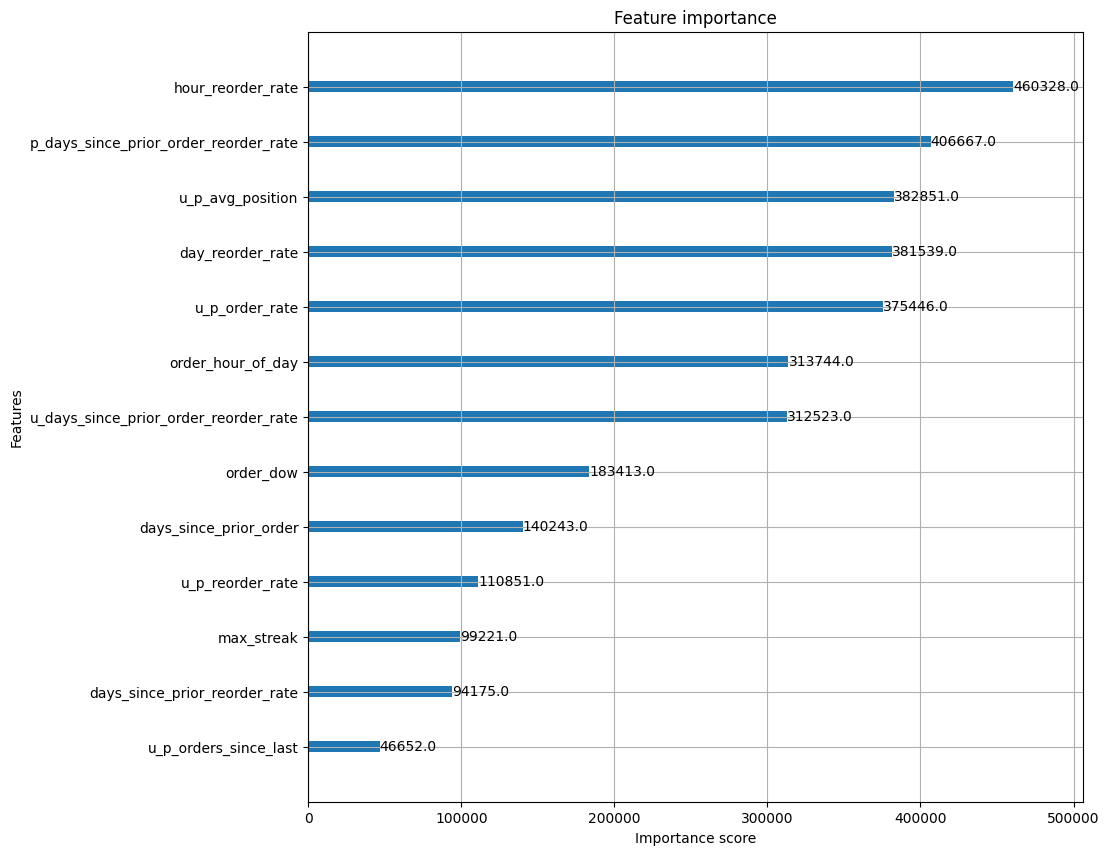

In [59]:
xgb_model, xgb_preds = train_xgb(X_train, X_val, y_train, y_val, file_name="xgb_model.pkl")


In [64]:
def train_catboost(X_train, X_test, y_train, y_test, plot_importance=True, save=True, file_name=None):
    """
    Train CatBoost model, log metrics and model with MLflow, and optionally save and plot importance.

    Returns:
        c_model: Trained CatBoost model
        predict_y: Predicted probabilities (class 1) for validation data
    """
    start_time = datetime.now()
    print("Training Started:")

    c_model = CatBoostClassifier(
        task_type="CPU",
        verbose=100,
        depth=13,
        iterations=2000,
        learning_rate=0.02,
        scale_pos_weight=1.0,
        random_seed=SEED_VALUE
    )

    with mlflow.start_run(run_name="catboost_model"):
        c_model.fit(X_train, y_train)

        print("Training Completed")
        end_time = datetime.now()
        duration = end_time - start_time
        hours, seconds = divmod(duration.total_seconds(), 3600)
        print(f"Total Time: {int(hours)} hours {int(seconds)} seconds")

        # Predict probabilities
        predict_proba = c_model.predict_proba(X_test)
        val_logloss = log_loss(y_test, predict_proba, labels=[0, 1])
        print("The Test log loss is:", val_logloss)

        # Log metrics
        mlflow.log_param("model_type", "CatBoostClassifier")
        mlflow.log_params({
            "depth": 13,
            "iterations": 2000,
            "learning_rate": 0.02,
            "scale_pos_weight": 1.0,
            "task_type": "CPU"
        })
        mlflow.log_metric("log_loss_val", val_logloss)
        mlflow.catboost.log_model(c_model, "catboost_model")

        # Save model
        if save and file_name:
            pickle.dump(c_model, open(file_name, "wb"))

        # Plot feature importance
        if plot_importance:
            feature_names = X_train.columns.to_numpy()
            f_imp = pd.DataFrame({
                'features': feature_names,
                'feature_importance': c_model.get_feature_importance()
            })
            f_imp.sort_values(by='feature_importance', ascending=False, inplace=True)

            print("Feature Importance")
            plt.figure(figsize=(10, 10))
            sns.barplot(x=f_imp['feature_importance'], y=f_imp['features'])
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()

        return c_model, predict_proba[:, 1]  # Return probability for class 1


Training Started:
0:	learn: 0.6686265	total: 620ms	remaining: 20m 39s
100:	learn: 0.2569739	total: 48.3s	remaining: 15m 7s
200:	learn: 0.2522283	total: 1m 36s	remaining: 14m 22s
300:	learn: 0.2511706	total: 2m 22s	remaining: 13m 24s
400:	learn: 0.2503280	total: 3m 11s	remaining: 12m 41s
500:	learn: 0.2494928	total: 3m 57s	remaining: 11m 49s
600:	learn: 0.2486898	total: 4m 44s	remaining: 11m 1s
700:	learn: 0.2478946	total: 5m 31s	remaining: 10m 15s
800:	learn: 0.2471541	total: 6m 20s	remaining: 9m 30s
900:	learn: 0.2464460	total: 7m 11s	remaining: 8m 46s
1000:	learn: 0.2457160	total: 8m 4s	remaining: 8m 3s
1100:	learn: 0.2450211	total: 8m 53s	remaining: 7m 15s
1200:	learn: 0.2443845	total: 9m 48s	remaining: 6m 31s
1300:	learn: 0.2437471	total: 10m 41s	remaining: 5m 44s
1400:	learn: 0.2431718	total: 11m 33s	remaining: 4m 56s
1500:	learn: 0.2425355	total: 12m 21s	remaining: 4m 6s
1600:	learn: 0.2418379	total: 13m 9s	remaining: 3m 16s
1700:	learn: 0.2411904	total: 13m 57s	remaining: 2m 27s

2025/06/15 19:01:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


The Test log loss is: 0.2510416613582631


python(87826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/06/15 19:01:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Importance


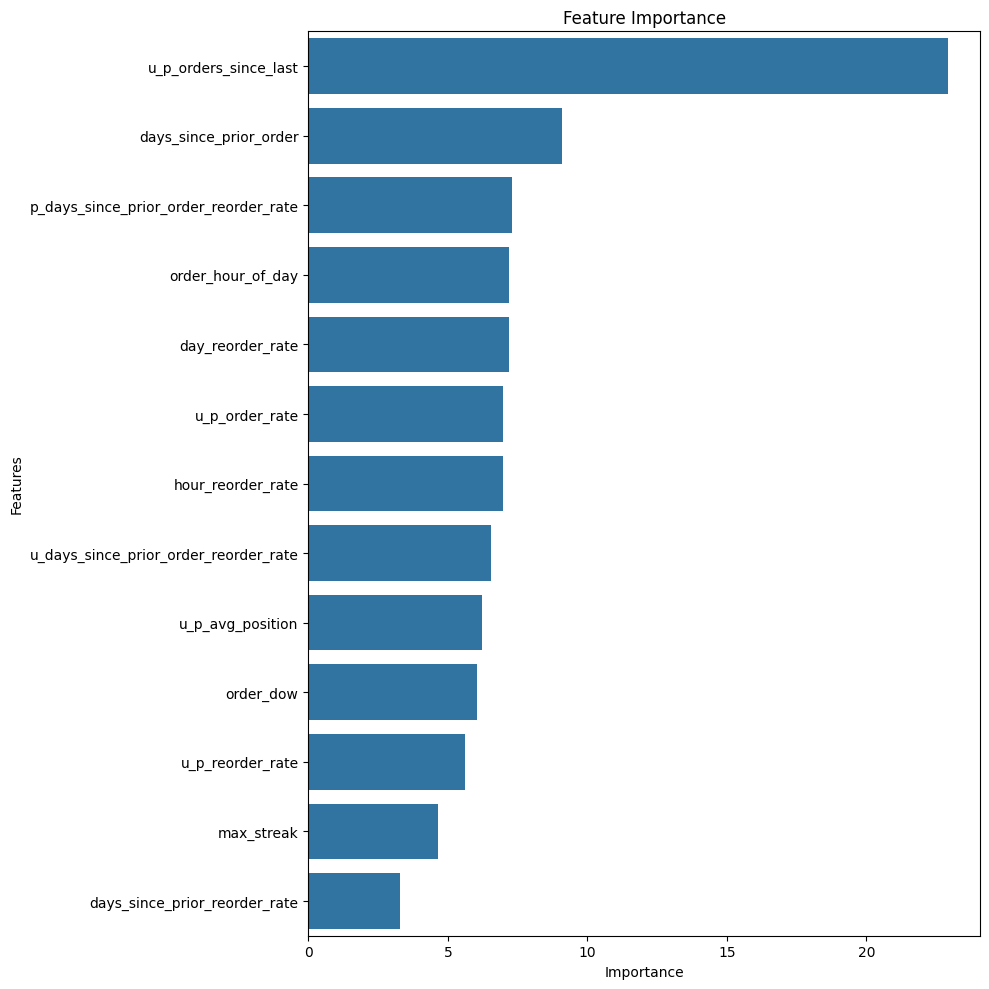

In [65]:
cat_model, cat_preds = train_catboost(X_train, X_val, y_train, y_val, file_name="catboost_model.pkl")


In [67]:
import os
if not os.path.exists("models"):
    os.mkdir("models")

In [68]:
x = data_files['prior_combined'].groupby(['order_dow', 'order_hour_of_day', 'product_name'])['product_name']\
    .count().reset_index(name='count').sort_values(by=['order_dow', 'order_hour_of_day', 'count'], ascending=False)

top10 = x.groupby(['order_dow', 'order_hour_of_day']).head(10).reset_index(drop=True)

# Save
top10.to_pickle("models/top10_products.pkl")


In [69]:
# Assume deployment date is 2021-03-21
user_last_purchase = data_files['train_combined'][['user_id', 'order_id']].drop_duplicates()
user_last_purchase['date'] = '2021-03-21'  # Fake date for all

# Save
user_last_purchase.to_pickle("models/user_last_purchase.pkl")


In [70]:
data_files['hour_reorder_rate'].to_pickle("models/hour_reorder_rate.pkl")
data_files['day_reorder_rate'].to_pickle("models/day_reorder_rate.pkl")
data_files['p_days_since_prior_order_reorder_rate'].to_pickle("models/p_days_since_prior_order_reorder_rate.pkl")
data_files['u_days_since_prior_order_reorder_rate'].to_pickle("models/u_days_since_prior_order_reorder_rate.pkl")
data_files['days_since_prior_reorder_rate'].to_pickle("models/days_since_prior_reorder_rate.pkl")
final_dataset[['user_id', 'product_id'] + feature_cols].to_pickle("models/merged_user_product_features.pkl")


In [71]:
product_map = data_files['train_combined'][['product_id', 'product_name']].drop_duplicates()
product_map.to_pickle("models/product_mappings.pkl")


In [3]:
X_train

NameError: name 'X_train' is not defined

In [75]:
ulp = pd.read_pickle("models/user_last_purchase.pkl")
print(ulp.head())
print(ulp['user_id'].dtype)

    user_id  order_id        date
0    112108         1  2021-03-21
8     79431        36  2021-03-21
16    42756        38  2021-03-21
25    17227        96  2021-03-21
32    56463        98  2021-03-21
int64


In [2]:
X_train

NameError: name 'X_train' is not defined